In [1]:
import numpy as np
import pandas as pd
from finta import TA
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import PrecisionRecallDisplay
import sklearn.metrics as skm
from joblib import Parallel, delayed
import joblib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# The trading algorithm will be tested and evaluated over three timelines:

# dcb = Dot Com Bubble
dcb_start = '1997-06-01'
dcb_end = '2002-12-01'

# crsh = 2008 Crash
crsh_start = '2007-06-01'
crsh_end = '2012-12-01'

# cvd = COVID-19
cvd_start = '2020-03-01'
cvd_end = '2022-06-01'

short_window = 4
long_window = 100
initial_capital = 100000.0
share_size = 100
start = crsh_start
end = crsh_end
# stock = 'S&P 500'
# stock = 'NASDAQ 100'
stock = 'RUSSELL 2000'

In [3]:
def get_under_over_signals(data=pd.DataFrame):
    
    df = data.drop(columns=['Open', 'Low', 'High'])

    df['Actual Returns'] = df['Close'].pct_change()

    df['Signal'] = 0.0
    df['Signal'] = np.where(
        (df['Actual Returns'] < 0), 1.0, 0.0
    )

    df = df.drop(columns=['Close', 'Actual Returns'])
    df = df.dropna().sort_index(axis='columns')

    return df

In [4]:
def get_fast_slow_sma(data=pd.DataFrame, short_window=short_window, long_window=long_window):

    df = data.drop(columns=['Open', 'Low', 'High'])

    # Generate the fast and slow simple moving averages
    df['sma_fast'] = (
        df['Close'].rolling(window=short_window).mean()
    )
    df['sma_slow'] = (
        df['Close'].rolling(window=long_window).mean()
    )

    # Sort the index
    df = df.drop(columns='Close').dropna().sort_index(axis='columns')

    return df

In [5]:
# Split any DataFrame into 75/25 train/test split
def get_training_dates(df):

    training_start = df.index.min()

    split_point = int(df.shape[0] * 0.75)
    training_end = df.iloc[split_point].name

    return training_start, training_end

In [6]:
# Always requires a 1D dataframe with a 'Close' column
def train_linear_svm(data=pd.DataFrame):

    df = data.dropna()

    X = get_fast_slow_sma(df)

    X_start = X.iloc[0].name
    X_end = X.iloc[-1].name

    y = get_under_over_signals(df[X_start:X_end])
    y = np.ravel(y)

    X_sc = StandardScaler().fit_transform(X)

    model = LinearSVC()
    model = model.fit(X_sc, y)

    return model

In [7]:
# Always requires a 1D dataframe with a 'Close' column
def train_model(data=pd.DataFrame, model_type=str):

    df = data.dropna()

    X = get_fast_slow_sma(df)

    X_start = X.iloc[0].name
    X_end = X.iloc[-1].name

    y = get_under_over_signals(df[X_start:X_end])
    y = np.ravel(y)

    X_sc = StandardScaler().fit_transform(X)

    if model_type == 'svc':
        model = SVC()
    elif model_type == 'linear_svc':
        model = LinearSVC()
    elif model_type == 'svr':
        model = SVR()
    else:
        model = SVC()

    model = model.fit(X_sc, y)
    
    return model

In [8]:
ohlc_df = pd.read_csv(
    'data/markets_ohlc.csv', 
    header=[0,1], 
    index_col=0, 
    infer_datetime_format=True, 
    parse_dates=True
)

ohlc_df = ohlc_df[stock].copy()

In [9]:
svm = train_model(ohlc_df, 'svc')
joblib.dump(svm, f'models/svm_{stock}.pkl')

['models/svm_RUSSELL 2000.pkl']

In [10]:
linear_svm = train_model(ohlc_df, 'linear_svc')
joblib.dump(linear_svm, f'models/linear_svm_{stock}.pkl')

['models/linear_svm_RUSSELL 2000.pkl']

In [11]:
svr = train_model(ohlc_df, 'svr')
joblib.dump(svr, f'models/svr_{stock}.pkl')

['models/svr_RUSSELL 2000.pkl']

In [22]:
def get_metrics(model, metric_type):

    X_test = get_fast_slow_sma(ohlc_df)
    X_test = X_test[start:end].copy()
    X_test_sc = StandardScaler().fit_transform(X_test)

    y_test = get_under_over_signals(ohlc_df[start:end]).values
    y_test = y_test.flatten()

    y_pred = model.predict(X_test_sc)
    y_pred = y_pred.flatten()

    # Regression metrics
    if metric_type == 'mse': 
        return skm.mean_squared_error(y_test, y_pred)
    elif metric_type == 'mae': 
        return skm.mean_absolute_error(y_test, y_pred)
    elif metric_type == 'evs':
        return skm.explained_variance_score(y_test, y_pred)
    elif metric_type == 'r2':
        return skm.r2_score(y_test, y_pred)

    # Classifier metrics
    elif metric_type == 'precision_recall_curve':
        display = PrecisionRecallDisplay.from_estimator(
            model, X_test, y_test, name="LinearSVC"
        )
        _ = display.ax_.set_title("Precision-Recall curve")
    elif metric_type == 'roc_auc_score': 
        return skm.roc_auc_score(y_test, y_pred)
    elif metric_type == 'roc_curve':
        y_score = model.decision_function(X_test)
        fpr, tpr, _ = skm.roc_curve(y_test, y_score)
        roc_auc = skm.auc(fpr, tpr)
        plt.figure(figsize=(10,8))
        lw = 2
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for SVM")
        plt.legend(loc="lower right")
        plt.show()

/Users/adam/miniconda3/envs/algotrading/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


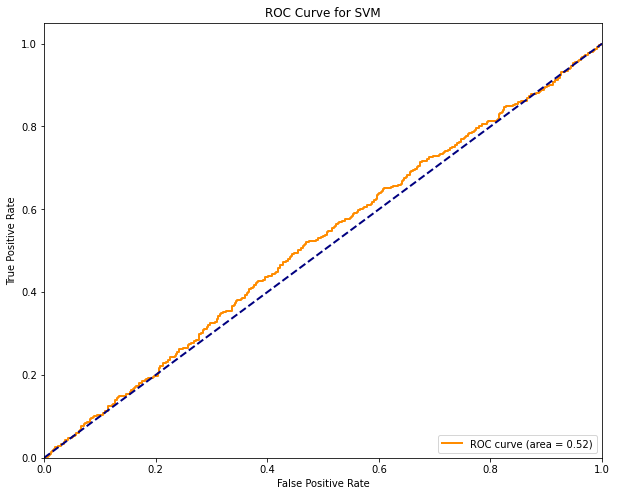

In [23]:
get_metrics(linear_svm, 'roc_curve')

/Users/adam/miniconda3/envs/algotrading/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


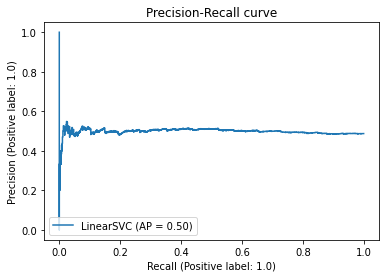

In [24]:
get_metrics(linear_svm, 'precision_recall_curve')

/Users/adam/miniconda3/envs/algotrading/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


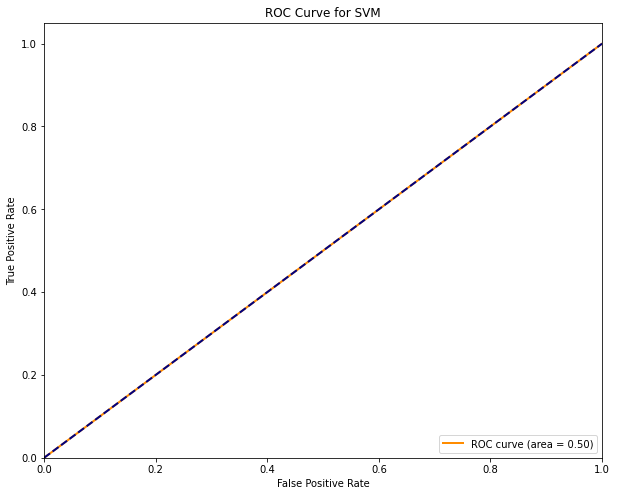

In [25]:
get_metrics(svm, 'roc_curve')

/Users/adam/miniconda3/envs/algotrading/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


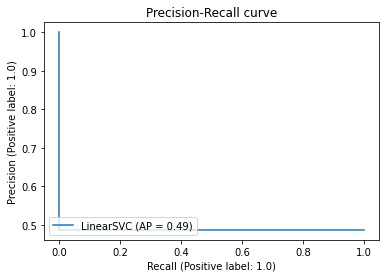

In [26]:
get_metrics(svm, 'precision_recall_curve')

In [17]:
get_metrics(svr, 'mse')


0.3866256109951161

In [18]:
get_metrics(svr, 'r2')

-0.5474878391099787